### Base CACTUS screen PacBio barcode fidelity analysis

This script generates various barcode fidelity plots beginning from PacBio fastqs along with barcode and construct references.

The 'pacbio_comboscreen_bc_and_construct_assignments.csv' file available on [Zenodo](https://zenodo.org/records/17594332) contains the barcode and construct assignments following alignment with minimap2.

Please contact hartmana@stanford.edu if interested in additional upstream data.

In [ ]:
import os
import time
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import itables
from itables import init_notebook_mode, show

from Bio import SeqIO
from Bio.Seq import Seq
import pysam

from ahocorasick import Automaton
import Levenshtein

In [ ]:
### files
base_path = "../pacbio_data/"

# CSVs
barcodes_csv = f"{base_path}/base_screen_barcodes_102625.csv"
constructs_csv = f"{base_path}/base_screen_sequences_102625.csv"

# FASTQ
fastq = f"{base_path}/fastq_files/m84127_250131_231902_s2.hifi_reads.bc2001.fastq.gz"

# Output CSVs
barcode_assignment_csv = f"{base_path}/results/pLIB216/pLIB216_barcode_assignments.csv"
construct_assignment_csv = f"{base_path}/results/pLIB216/pLIB216_construct_assignments.csv"

# Constructs sorted BAM
final_bam = f"{base_path}/results/bc2001_minimap.sorted.bam"

# export necessary variables for bash script
os.environ["CONSTRUCTS_CSV"] = constructs_csv
os.environ["CONSTRUCTS_FASTA"] = constructs_csv.replace(".csv", ".fasta")
os.environ["CONSTRUCTS_MINIMAP_IDX"] = constructs_csv.replace(".csv", ".mmi")
os.environ["FASTQ_PATH"] = fastq

os.environ["SAM_PATH"] = f"{base_path}/results/bc2001_minimap.sam"
os.environ["BAM_PATH"] = f"{base_path}/results/bc2001_minimap.bam"
os.environ["BAM_SORTED_PATH"] = final_bam

In [ ]:
bcs = pd.read_csv(barcodes_csv)
bcs.head()
d = bcs.set_index('sequence')['name'].to_dict()

barcodes_fasta_dict = {}
for key, value in d.items():
    barcodes_fasta_dict["AGCG" + key] = value # AGCG already appended on the end
original_fasta_dict = barcodes_fasta_dict.copy()
for seq, name in original_fasta_dict.items():
    rev_comp_seq = str(Seq(seq).reverse_complement())
    barcodes_fasta_dict[rev_comp_seq] = name + "_revcomp"

automaton = Automaton()
for seq, name in barcodes_fasta_dict.items():
    automaton.add_word(seq, name)
automaton.make_automaton()

# iterate over fastq and identify barcodes
start = time.time()
bcs_dict = dict()
counter = 0
open_fn = gzip.open if fastq.endswith('.gz') else open
with open_fn(fastq, "rt") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        counter += 1
        read_seq = str(record.seq)
        matches = set(name for _, name in automaton.iter(read_seq))
        bcs_dict[record.id] = list(matches)
        if counter % 100000 == 0:
            print(counter, record.id, bcs_dict[record.id])
end = time.time()
print(end - start)

# save the results
columns = ["Key", "Barcodes"]
data_list = []
for key, values in bcs_dict.items():
    if len(values) == 0:
        row = {"Key": key, "Barcodes": ""}
    else:
        row = {"Key": key, "Barcodes": values[0]}
    data_list.append(row)
df = pd.DataFrame(data_list, columns=columns)
df = df.set_index('Key')
df.to_csv(barcode_assignment_csv)

100000 m84127_250131_231902_s2/93585734/ccs ['Kingcup-Signaling_41BB-LAT-LAT-CD3Z']
200000 m84127_250131_231902_s2/108397794/ccs []
300000 m84127_250131_231902_s2/11210568/ccs ['Fishhook-Binder_Carvykti scFV', 'Kingcup-Signaling_CD28z']
400000 m84127_250131_231902_s2/89657821/ccs ['Torch-KD_PRKAR1A']
500000 m84127_250131_231902_s2/198906766/ccs ['Torch-KD_TADA2B']
42.54185891151428


#### Convert constructs CSV into a FASTA for minimap2 to read in

In [ ]:
%%bash
# convert CSV to a fasta
awk -F',' 'NR>1{printf ">%s\n%s\n", $1, $2}' "${CONSTRUCTS_CSV}" > "${CONSTRUCTS_FASTA}"
# run minimap2 with PacBio HiFi presets
time minimap2 -t 12 -ax map-hifi ${CONSTRUCTS_FASTA} ${FASTQ_PATH} | samtools view -@2 -b | samtools sort -@2 -o ${BAM_SORTED_PATH}
samtools index ${BAM_SORTED_PATH}

[M::mm_idx_gen::0.009*1.13] collected minimizers
[M::mm_idx_gen::0.012*2.23] sorted minimizers
[M::main::0.013*2.22] loaded/built the index for 656 target sequence(s)
[M::mm_mapopt_update::0.013*2.15] mid_occ = 353
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 656
[M::mm_idx_stat::0.014*2.11] distinct minimizers: 28504 (96.28% are singletons); average occurrences: 1.405; average spacing: 10.458; total length: 418957


[M::worker_pipeline::35.938*11.26] mapped 129068 sequences
[M::worker_pipeline::65.113*11.69] mapped 129325 sequences
[M::worker_pipeline::97.989*11.85] mapped 128623 sequences
[M::worker_pipeline::121.792*11.64] mapped 127724 sequences
[M::main] Version: 2.28-r1209
[M::main] CMD: minimap2 -t 12 -ax map-hifi /home/hartmana_stanford_edu/projects/pacbio_crispr_all/input_csvs/base_screen_sequences_102625.fasta /home/hartmana_stanford_edu/projects/pacbio_crispr_all/fastq_files/m84127_250131_231902_s2.hifi_reads.bc2001.fastq.gz
[M::main] Real time: 121.848 sec; CPU: 1417.342 sec; Peak RSS: 2.317 GB
[bam_sort_core] merging from 1 files and 2 in-memory blocks...

real	2m12.164s
user	24m33.016s
sys	0m8.199s


In [ ]:
# Gather construct alignments from BAM file

start = time.time()

bam_file = final_bam
base = dict()
with pysam.AlignmentFile(bam_file, "rb") as f:
    for read in f.fetch():
        base[read.query_name] = read.reference_name
print("Base library done")

df = pd.DataFrame({'construct': base})
df.index.name = 'Key'
df.to_csv(construct_assignment_csv)

end = time.time()
print(end - start)

Base library done
2.8620376586914062


### Build merged dataframe

In [ ]:
# load in construct assignments and barcode assignments and merge into a single dataframe
# where each row represents a single read

constructs_df = pd.read_csv(construct_assignment_csv)
constructs_df.columns = ["ID", "construct"]
# modify names slightly to match the names of construct barcodes
constructs_df['construct'] = constructs_df['construct'].str.replace(".v1", '')
constructs_df['construct'] = constructs_df['construct'].str.replace("_|\\.|-| |\\+|\\)|\\(", '', case=False, regex=True)

barcodes_df = pd.read_csv(barcode_assignment_csv)
barcodes_df.columns = ["ID", "barcode"]
barcodes_df['barcode'] = barcodes_df['barcode'].str.replace('_revcomp', '')
barcodes_df['barcode'] = barcodes_df['barcode'].str.replace(r"Over|KO|-KD|Signaling|Syn|Binder|scFV", '', case=False, regex=True)
barcodes_df['barcode'] = barcodes_df['barcode'].str.replace('_|\\.|-| |\\+|\\)|\\(', '', case=False, regex=True)
barcodes_df['barcode'] = barcodes_df['barcode'].str.replace('CardonCAR', 'Cardon')

barcodes_df = barcodes_df.set_index('ID')
constructs_df = constructs_df.set_index('ID')
merged_df = pd.merge(barcodes_df, constructs_df, left_index=True, right_index=True, how='outer')  # how='outer' for all IDs

# remove the barcodes for constructs which were excluded from quantification
merged_df = merged_df.dropna()
nreads = barcodes_df.shape[0]
valid_constructs = constructs_df.dropna().shape[0]

# what percentage of barcode-construct pairs are correct when each is detected for a given read
fidelity = sum(merged_df.barcode == merged_df.construct) / merged_df.shape[0]
print(f"Num. detected constructs: {valid_constructs}")
print(f"Overall fidelity:         {round(fidelity*100, 2)}%")
print(merged_df.head())


List of unique Fishhook constructs:
['Fishhook47G4', 'FishhookCarvykti', 'FishhookSJ25C1', 'Fishhookbudoprutug', 'Fishhookloncastuximab']

List of unique Fishhook barcode:
['Fishhook25C2', 'Fishhook47G4', 'FishhookAbecma', 'FishhookCAT131E10', 'FishhookCarvykti', 'FishhookSJ25C1', 'Fishhookblinatumomab', 'Fishhookbudoprutug', 'Fishhookcoltuximab', 'Fishhookdenintuzumab', 'Fishhookduvortuxizumab', 'Fishhookemfizatamab', 'Fishhookinebilizumab', 'Fishhookloncastuximab', 'Fishhooktafasitamab', 'Fishhookzeripatamig']
Num. detected constructs: 474346
Overall fidelity:         89.09%
                                                   barcode        construct
ID                                                                         
m84127_250131_231902_s2/100007956/ccs       CardonYescarta   CardonYescarta
m84127_250131_231902_s2/100008059/ccs         TorchBHLHE40        TorchALX1
m84127_250131_231902_s2/100008063/ccs           ChollaCD59      ChollaMED12
m84127_250131_231902_s2/100008074/c

In [ ]:
# Constructs containing Fishook constructs frequently align to the Kingcup signaling domain
# which matches the sequences of the signaling domain used in the base CD19-CD28z CAR construct
mask_fishhook = merged_df['barcode'].str.startswith('Fishhook', na=False)
merged_df[merged_df['barcode'].isin(merged_df.loc[mask_fishhook, 'barcode'].unique())].tail(20)

,barcode,construct
ID,,
m84127_250131_231902_s2/98243374/ccs,FishhookCarvykti,KingcupCD28z
m84127_250131_231902_s2/98308138/ccs,FishhookCarvykti,KingcupCD28z
m84127_250131_231902_s2/98435763/ccs,FishhookCarvykti,KingcupCD28z
m84127_250131_231902_s2/98502491/ccs,FishhookSJ25C1,KingcupCD28z
m84127_250131_231902_s2/98504178/ccs,Fishhook47G4,KingcupCD28z
m84127_250131_231902_s2/98633055/ccs,FishhookCarvykti,KingcupCD28z
m84127_250131_231902_s2/98763178/ccs,FishhookCarvykti,KingcupCD28z
m84127_250131_231902_s2/98763930/ccs,Fishhookbudoprutug,SaguaroPPARGC1A
m84127_250131_231902_s2/98898006/ccs,Fishhook47G4,KingcupCD28z


In [ ]:
# drop the Fishhook entries due frequent 'off-target' alignments
mask_fishhook = merged_df['barcode'].str.startswith('Fishhook', na=False)
merged_df = merged_df[~mask_fishhook]
mark_fishhook = merged_df['construct'].str.startswith('Fishhook', na=False)
merged_df = merged_df[~mark_fishhook]

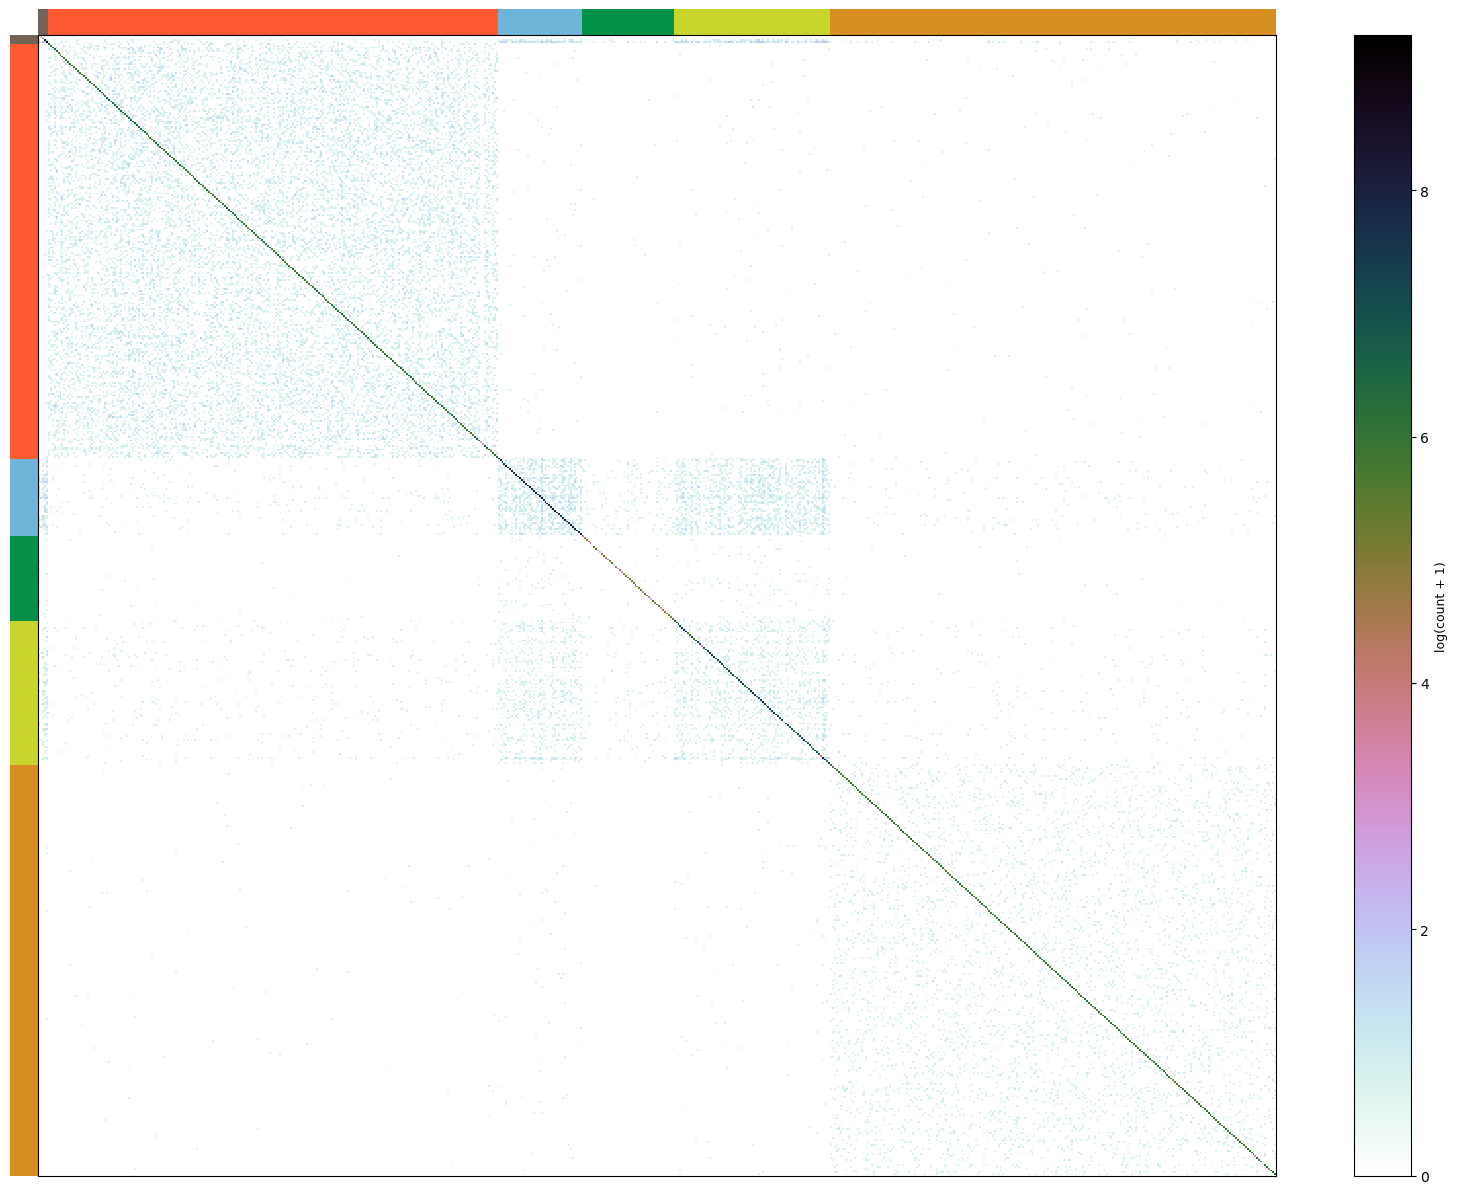

In [ ]:
# Define color map for prefixes
prefix_colors = {
    "Fishhook": "#1b75bb",
    "Saguaro": "#c8d52c",
    "Torch": "#d88d21",
    "Cholla": "#FF5A32",
    "Cardon": "#736357",
    "PricklyPear": "#019147",
    "Kingcup": "#6fb5d9",
}

count_df = (merged_df.groupby(['barcode', 'construct']).size().unstack(fill_value=0).T)

def get_prefix_color(name):
    for prefix, color in prefix_colors.items():
        if str(name).startswith(prefix):
            return color
    return "#cccccc"

x_colors = [get_prefix_color(c) for c in count_df.columns]
y_colors = [get_prefix_color(r) for r in count_df.index]

fig, ax = plt.subplots(figsize=(16, 12))
log_df = np.log1p(count_df)
im = ax.imshow(log_df.values, aspect='auto', cmap='cubehelix_r', interpolation='nearest')

# add some bars indicating the type of barcode & construct
bar_thickness = 15.0
for i, color in enumerate(x_colors):
    ax.add_patch(
        patches.Rectangle(
            (i - 0.5, -bar_thickness),
            1,
            bar_thickness,
            transform=ax.transData,
            color=color,
            clip_on=False,
            linewidth=0))

for j, color in enumerate(y_colors):
    ax.add_patch(
        patches.Rectangle(
            (-bar_thickness, j - 0.5),
            bar_thickness,
            1,
            transform=ax.transData,
            color=color,
            clip_on=False,
            linewidth=0))

plt.xlabel("", fontsize=10)
plt.ylabel("", fontsize=10)
plt.title("", fontsize=12)

ax.set_xticks([])
ax.set_yticks([])

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("log(count + 1)", fontsize=9)

plt.tight_layout()
plt.show()

fig.savefig(f"/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/pLIB216_barcode_construct_heatmap.png", dpi=300)

In [96]:
# Create a new column in merged_df that includes the construct prefix if it matches specific prefixes
def construct_prefix(row):
    prefixes = {
        'Torch': 'Torch',
        'Cholla': 'Cholla',
        'Saguaro': 'Saguaro',
        'PricklyPear': 'PricklyPear',
        'Kingcup': 'Kingcup',
        "Cardon": "Cardon",
        "Fishhook": "Fishhook"
    }
    for prefix, value in prefixes.items():
        if row['construct'].startswith(prefix):
            return value
    return "unknown"

def barcode_prefix(row):
    prefixes = {
        'Torch': 'Torch',
        'Cholla': 'Cholla',
        'Saguaro': 'Saguaro',
        'PricklyPear': 'PricklyPear',
        'Kingcup': 'Kingcup',
        "Cardon": "Cardon",
        "Fishhook": "Fishhook"
    }
    for prefix, value in prefixes.items():
        if row['barcode'].startswith(prefix):
            return value
    return "unknown" 

merged_df['construct_prefix'] = merged_df.apply(construct_prefix, axis=1)
merged_df['barcode_prefix'] = merged_df.apply(barcode_prefix, axis=1)

merged_df.head()

,barcode,construct,construct_prefix,barcode_prefix
ID,,,,
m84127_250131_231902_s2/100007956/ccs,CardonYescarta,CardonYescarta,Cardon,Cardon
m84127_250131_231902_s2/100008059/ccs,TorchBHLHE40,TorchALX1,Torch,Torch
m84127_250131_231902_s2/100008063/ccs,ChollaCD59,ChollaMED12,Cholla,Cholla
m84127_250131_231902_s2/100008074/ccs,SaguaroAIFM2,SaguaroAIFM2,Saguaro,Saguaro
m84127_250131_231902_s2/100008094/ccs,KingcupCD28PYAPonly,KingcupCD28PYAP,Kingcup,Kingcup


In [99]:
# save merged_df to csv
merged_df.to_csv(f"{base_path}/results/pLIB216/pLIB216_merged_barcode_construct_assignments.csv")

In [24]:
counts_per_barcode = (
    merged_df
    .groupby(['barcode_prefix', 'barcode'])
    .size()
    .reset_index(name='count')
)
counts_per_barcode.head()

# sort counts_per_barcode by barcode_prefix and count in descending order
counts_per_barcode = counts_per_barcode.sort_values(by=['barcode_prefix', 'count'], ascending=[True, False])
counts_per_barcode.tail()

,barcode_prefix,barcode,count
573,synthetic,PricklyPearTGFBR1IL12R1TGFBR2IL12R2,13
546,synthetic,PricklyPearCTLA4dn,12
547,synthetic,PricklyPearCγCRCD122,5
554,synthetic,PricklyPearGM18,5
543,synthetic,PricklyPearCD200dn,1


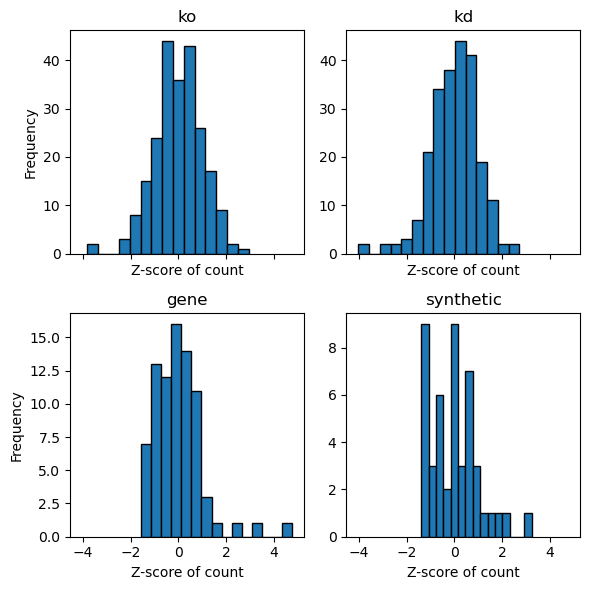

In [35]:
# build three histograms (ko, kd, gene) with the same axes range
prefixes = ['ko', 'kd', 'gene', 'synthetic']
dfs = {}
for p in prefixes:
    sub = counts_per_barcode[counts_per_barcode['barcode_prefix'] == p].copy()
    if sub.empty:
        dfs[p] = sub
        continue
    std = sub['count'].std()
    if std == 0 or np.isnan(std):
        sub['zscore_count'] = 0.0
    else:
        sub['zscore_count'] = (sub['count'] - sub['count'].mean()) / std
    dfs[p] = sub

# determine common x-range for z-scores
all_z = pd.concat([df['zscore_count'] for df in dfs.values() if not df.empty])
if all_z.empty:
    xmin, xmax = -3, 3
else:
    xmin, xmax = all_z.min(), all_z.max()
    # pad a bit
    pad = max(0.5, 0.05 * (xmax - xmin))
    xmin, xmax = xmin - pad, xmax + pad

# plot side-by-side with same axes
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=False)
axes_flat = axes.flatten()
bins = 15

for ax, p in zip(axes_flat, prefixes):
    dfp = dfs[p]
    if dfp.empty:
        ax.text(0.5, 0.5, f'No data for {p}', ha='center', va='center')
        ax.set_xlim(xmin, xmax)
        ax.set_title(p)
        ax.set_xlabel('Z-score of count')
        continue
    ax.hist(dfp['zscore_count'], bins=bins, color='C0', edgecolor='black')
    ax.set_xlim(xmin, xmax)
    ax.set_title(p)
    ax.set_xlabel('Z-score of count')

# y-labels on left column
axes_flat[0].set_ylabel('Frequency')
axes_flat[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# save plot
fig.savefig(f"{base_path}/results/pLIB216/pLIB216_barcode_count_zscore_histograms.svg", format='svg')

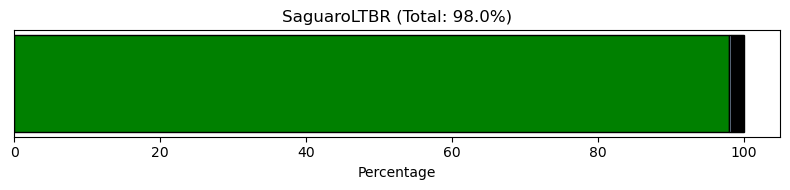

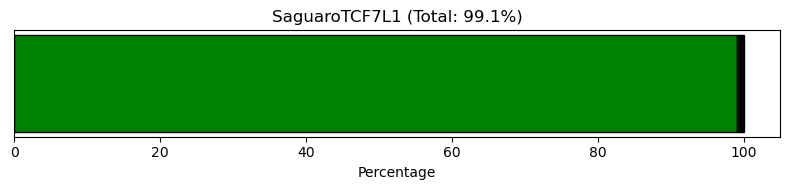

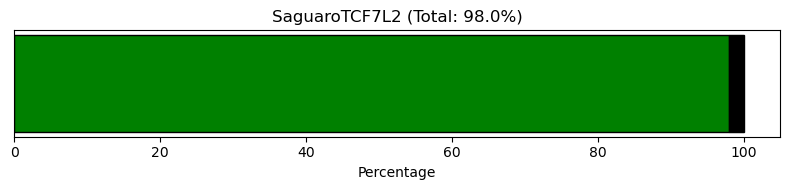

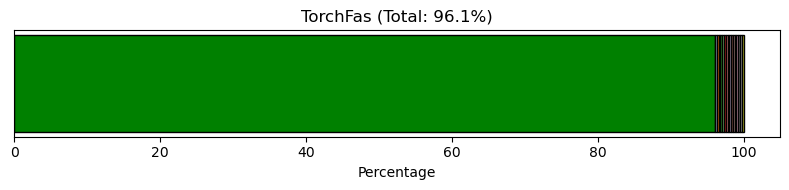

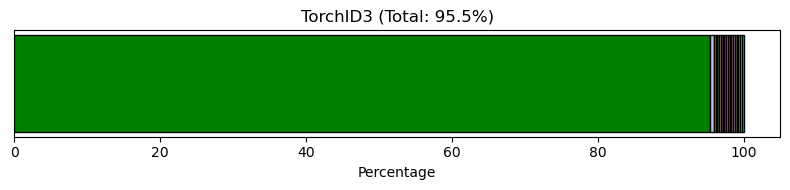

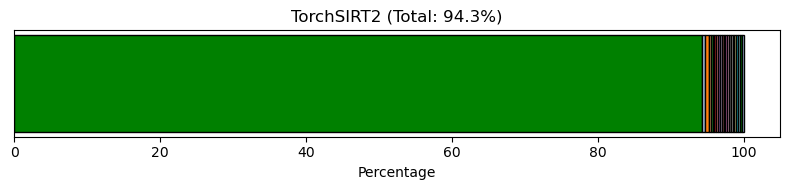

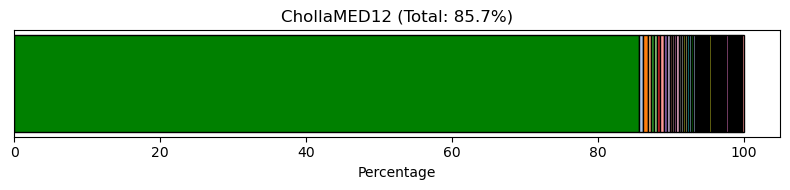

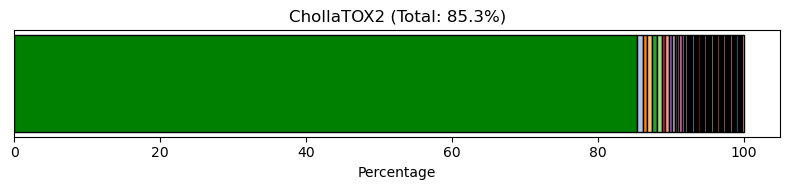

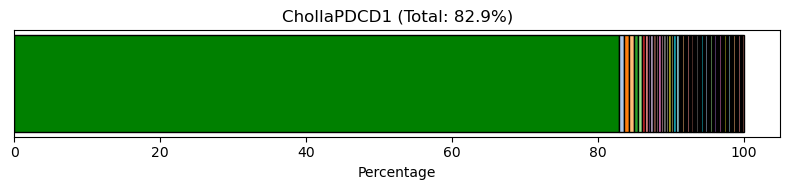

In [ ]:
# generate bar plots displaying the percentage of each assigned construct
# when a given barcode is detected

def plot_barcode_distribution(df, ko_value):
    filtered_df = df[df['construct'] == ko_value]
    counts = filtered_df['barcode'].value_counts(normalize=True) * 100  # Calculate percentages
    total_percentage=counts[ko_value]
    
    plt.figure(figsize=(8, 2))
    bottom = 0
    colors = list(plt.cm.tab20.colors)  # Use a colormap for distinct colors
    colors[0] = 'green'  # Set the first color to green
    for i, (barcode, percentage) in enumerate(counts.items()):
        plt.barh(0, percentage, left=bottom, color=colors[i % len(colors)], edgecolor="black", label=f"{barcode}: {percentage:.1f}%")
        bottom += percentage
    
    plt.xlabel('Percentage')
    plt.title(f'{ko_value} (Total: {total_percentage:.1f}%)')  # Add total percentage to the title
    plt.yticks([])
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(f"/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/{ko_value}_barcode_distribution.svg")
    plt.show()

ss = merged_df[merged_df['barcode_prefix'] == "gene"]
plot_barcode_distribution(ss, "SaguaroLTBR")
plot_barcode_distribution(ss, "SaguaroTCF7L1")
plot_barcode_distribution(ss, "SaguaroTCF7L2")


ss = merged_df[merged_df['barcode_prefix'] == "kd"]
plot_barcode_distribution(ss, "TorchFas")
plot_barcode_distribution(ss, "TorchID3")
plot_barcode_distribution(ss, "TorchSIRT2")

ss = merged_df[merged_df['barcode_prefix'] == "ko"]
plot_barcode_distribution(ss, "ChollaMED12")
plot_barcode_distribution(ss, "ChollaTOX2")
plot_barcode_distribution(ss, "ChollaPDCD1")

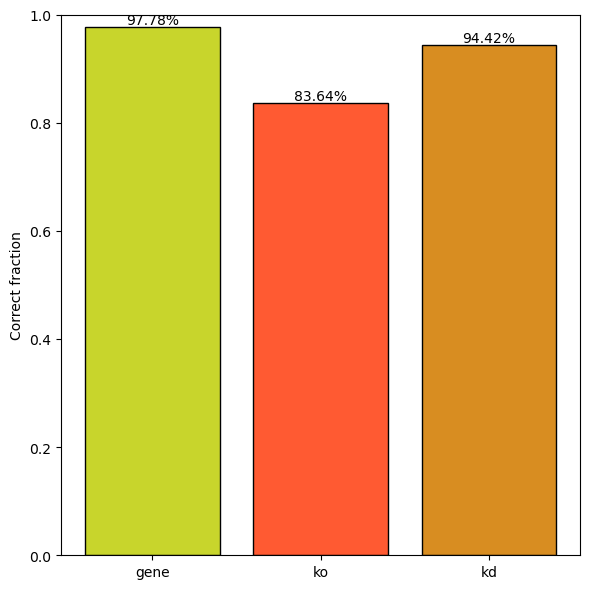

In [ ]:
# Bar plot with overall correctness for each type of perturbation

categories = ['gene', 'ko', 'kd']
correctness = {}

for category in categories:
    subset = merged_df[merged_df['construct_prefix'] == category]
    correctness[category] = (subset['barcode'] == subset['construct']).mean()

# Create a bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(correctness.keys(), correctness.values(), color=["#C8D52C", "#FF5A32", "#D88D21"], edgecolor='black')
plt.ylim(0, 1)
plt.ylabel('Correct fraction')
plt.title("")

# Add text percentage to each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/base_screen_modification_correct_rate_bar_plot.svg", format="svg")
plt.show()


In [ ]:
# Define the categories
categories = ['ko', 'kd', 'gene']
cols = ['construct_prefix', 'barcode_prefix']
data = []

for cat in categories:
    for col in cols:
        ss = merged_df[merged_df[col] == cat]
        if col == 'construct_prefix':
            enrichment = np.log2(ss['construct'].value_counts() / ss['construct'].value_counts().mean())
            for construct, value in enrichment.items():
                data.append({"enrichment": value, "category": cat})
        else:
            enrichment = np.log2(ss['barcode'].value_counts() / ss['barcode'].value_counts().mean())
            for construct, value in enrichment.items():
                data.append({"enrichment": value, "category": cat+"_bc"})            

# Create a df from the collected data
enrichment_df = pd.DataFrame(data)
print(enrichment_df.head())

   enrichment category
0    0.808803       ko
1    0.600456       ko
2    0.580754       ko
3    0.577143       ko
4    0.564432       ko


In [69]:
merged_df.head()

,barcode,construct,construct_prefix,barcode_prefix,is_correct
ID,,,,,
m84127_250131_231902_s2/100008059/ccs,TorchBHLHE40,TorchALX1,kd,kd,False
m84127_250131_231902_s2/100008063/ccs,ChollaCD59,ChollaMED12,ko,ko,False
m84127_250131_231902_s2/100008074/ccs,SaguaroAIFM2,SaguaroAIFM2,gene,gene,True
m84127_250131_231902_s2/100008300/ccs,SaguaroBATF3,SaguaroBATF3,gene,gene,True
m84127_250131_231902_s2/100008446/ccs,ChollaDnmt3a,ChollaDnmt3a,ko,ko,True


<Axes: xlabel='count', ylabel='Density'>

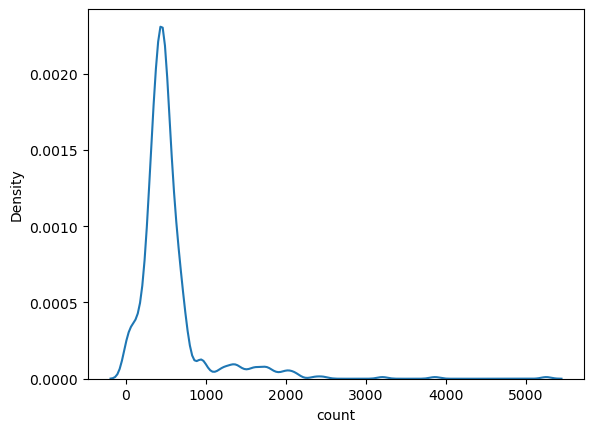

In [76]:
values = merged_df.construct.value_counts()
sns.kdeplot(values, bw_adjust=0.5)


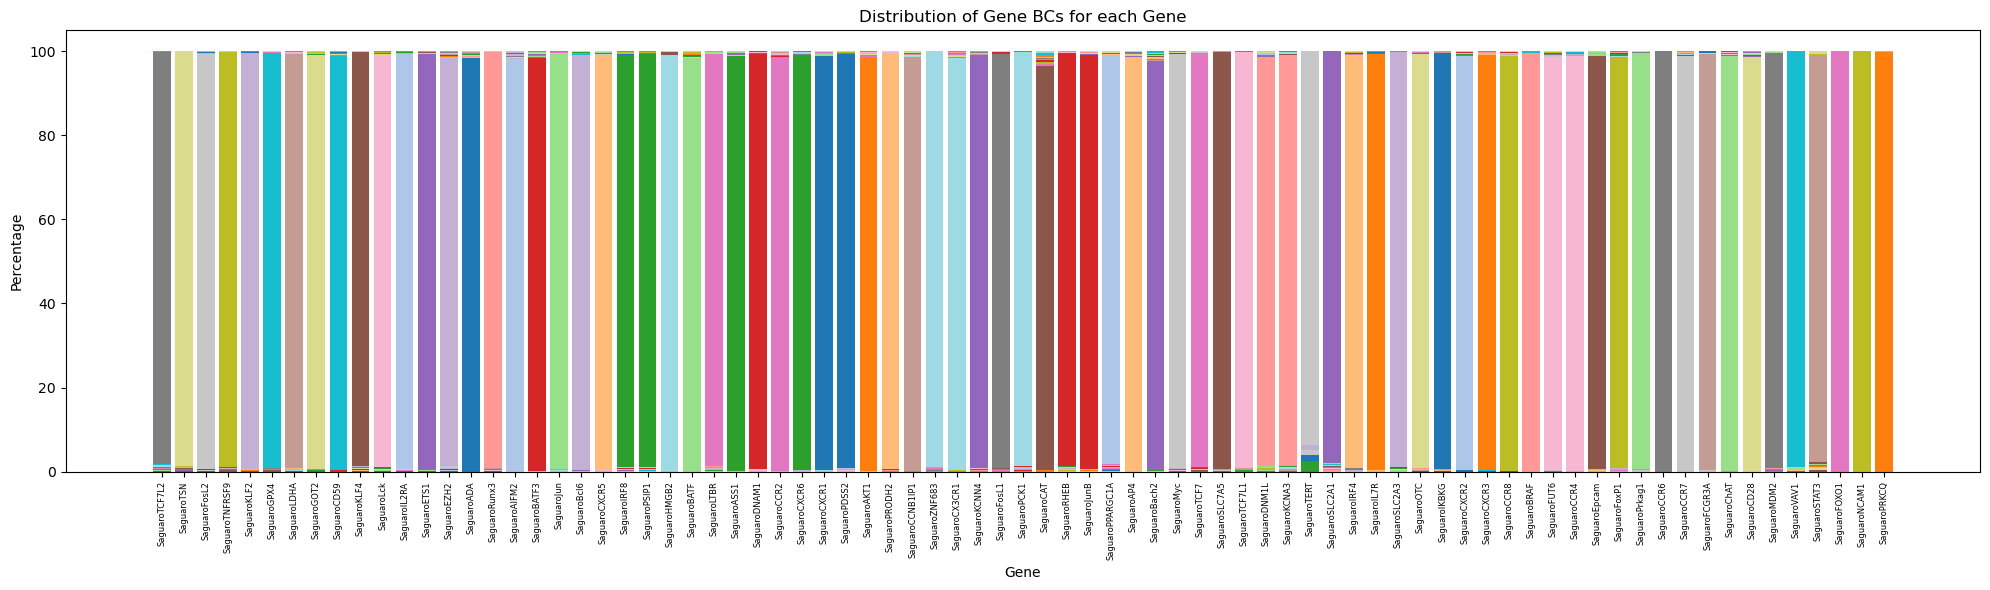

In [45]:
# Aggregate data for the bar plot
ss = merged_df[(merged_df['construct_prefix'] == "gene") & (merged_df['barcode_prefix'] == "gene")]
data = []
unique_genes = ss['construct'].dropna().unique()
for gene in unique_genes:
    filtered_df = ss[ss['construct'] == gene]
    counts = filtered_df['barcode'].value_counts(normalize=True) * 100
    for barcode, percentage in counts.items():
        data.append({'construct': gene, 'barcode': barcode, 'percentage': percentage})

plot_data = pd.DataFrame(data)

plot_data.head()
plt.figure(figsize=(20, 6))
colors = plt.cm.tab20.colors  # Use a colormap for distinct colors
bottoms = {construct: 0 for construct in unique_genes}
for i, (barcode, group) in enumerate(plot_data.groupby('barcode')):
    percentages = group.set_index('construct')['percentage']
    plt.bar(percentages.index, percentages, bottom=[bottoms[gene] for gene in percentages.index],
            color=colors[i % len(colors)], edgecolor='none', linewidth=0, label=barcode)
    for gene in percentages.index:
        bottoms[gene] += percentages[gene]

# Add labels and legend
plt.ylabel('Percentage')
plt.xlabel('Gene')
plt.xticks(fontsize=6)
plt.title('Distribution of Gene BCs for each Gene')
plt.xticks(rotation=90)
plt.legend().remove()
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/base_gene_distribution.svg", format="svg")
plt.show()

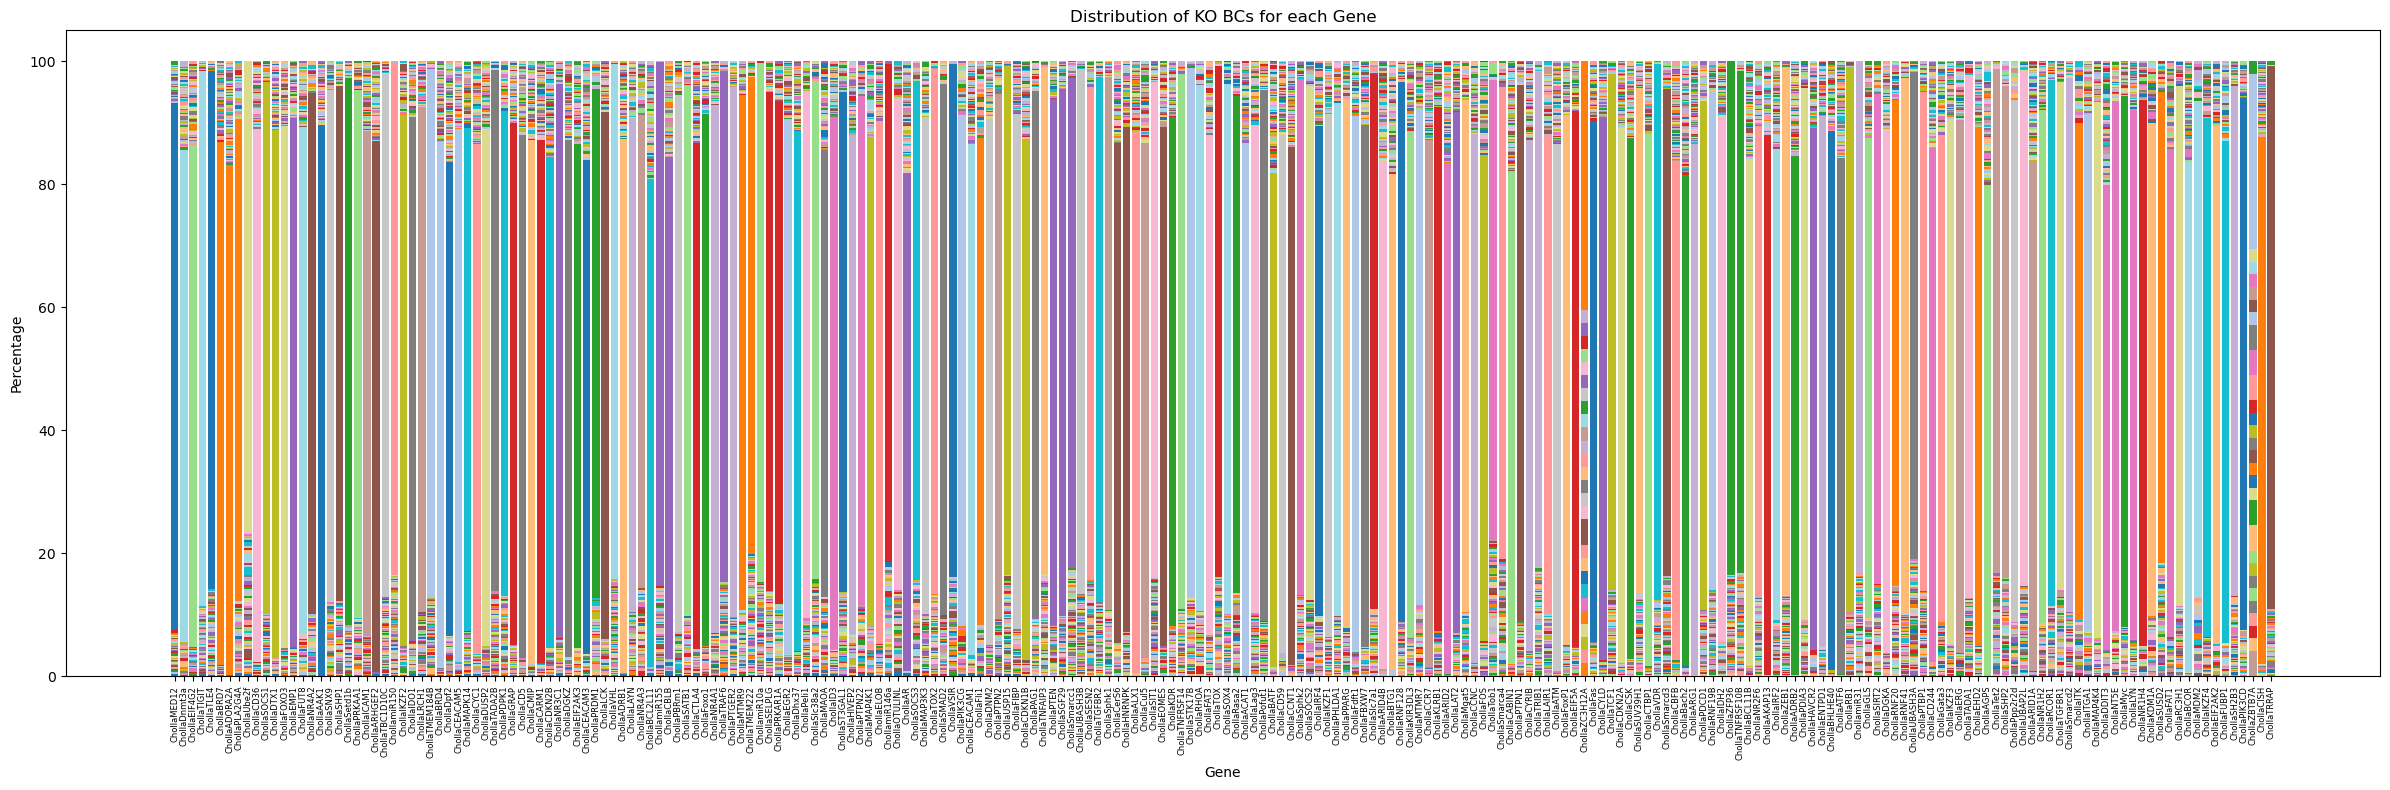

In [46]:
# Aggregate data for the bar plot
ss = merged_df[(merged_df['construct_prefix'] == "ko") & (merged_df['barcode_prefix'] == "ko")]
data = []
unique_genes = ss['construct'].dropna().unique()
for gene in unique_genes:
    filtered_df = ss[ss['construct'] == gene]
    counts = filtered_df['barcode'].value_counts(normalize=True) * 100
    for barcode, percentage in counts.items():
        data.append({'construct': gene, 'barcode': barcode, 'percentage': percentage})

plot_data = pd.DataFrame(data)

plot_data.head()
plt.figure(figsize=(24, 8))
colors = plt.cm.tab20.colors  # Use a colormap for distinct colors
bottoms = {construct: 0 for construct in unique_genes}
for i, (barcode, group) in enumerate(plot_data.groupby('barcode')):
    percentages = group.set_index('construct')['percentage']
    plt.bar(percentages.index, percentages, bottom=[bottoms[gene] for gene in percentages.index],
            color=colors[i % len(colors)], edgecolor='none', linewidth=0, label=barcode)
    for gene in percentages.index:
        bottoms[gene] += percentages[gene]

# Add labels and legend
plt.ylabel('Percentage')
plt.xlabel('Gene')
plt.xticks(fontsize=6)
plt.title('Distribution of KO BCs for each Gene')
plt.xticks(rotation=90)
plt.legend().remove()
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/base_ko_distribution.svg", format="svg")
plt.show()

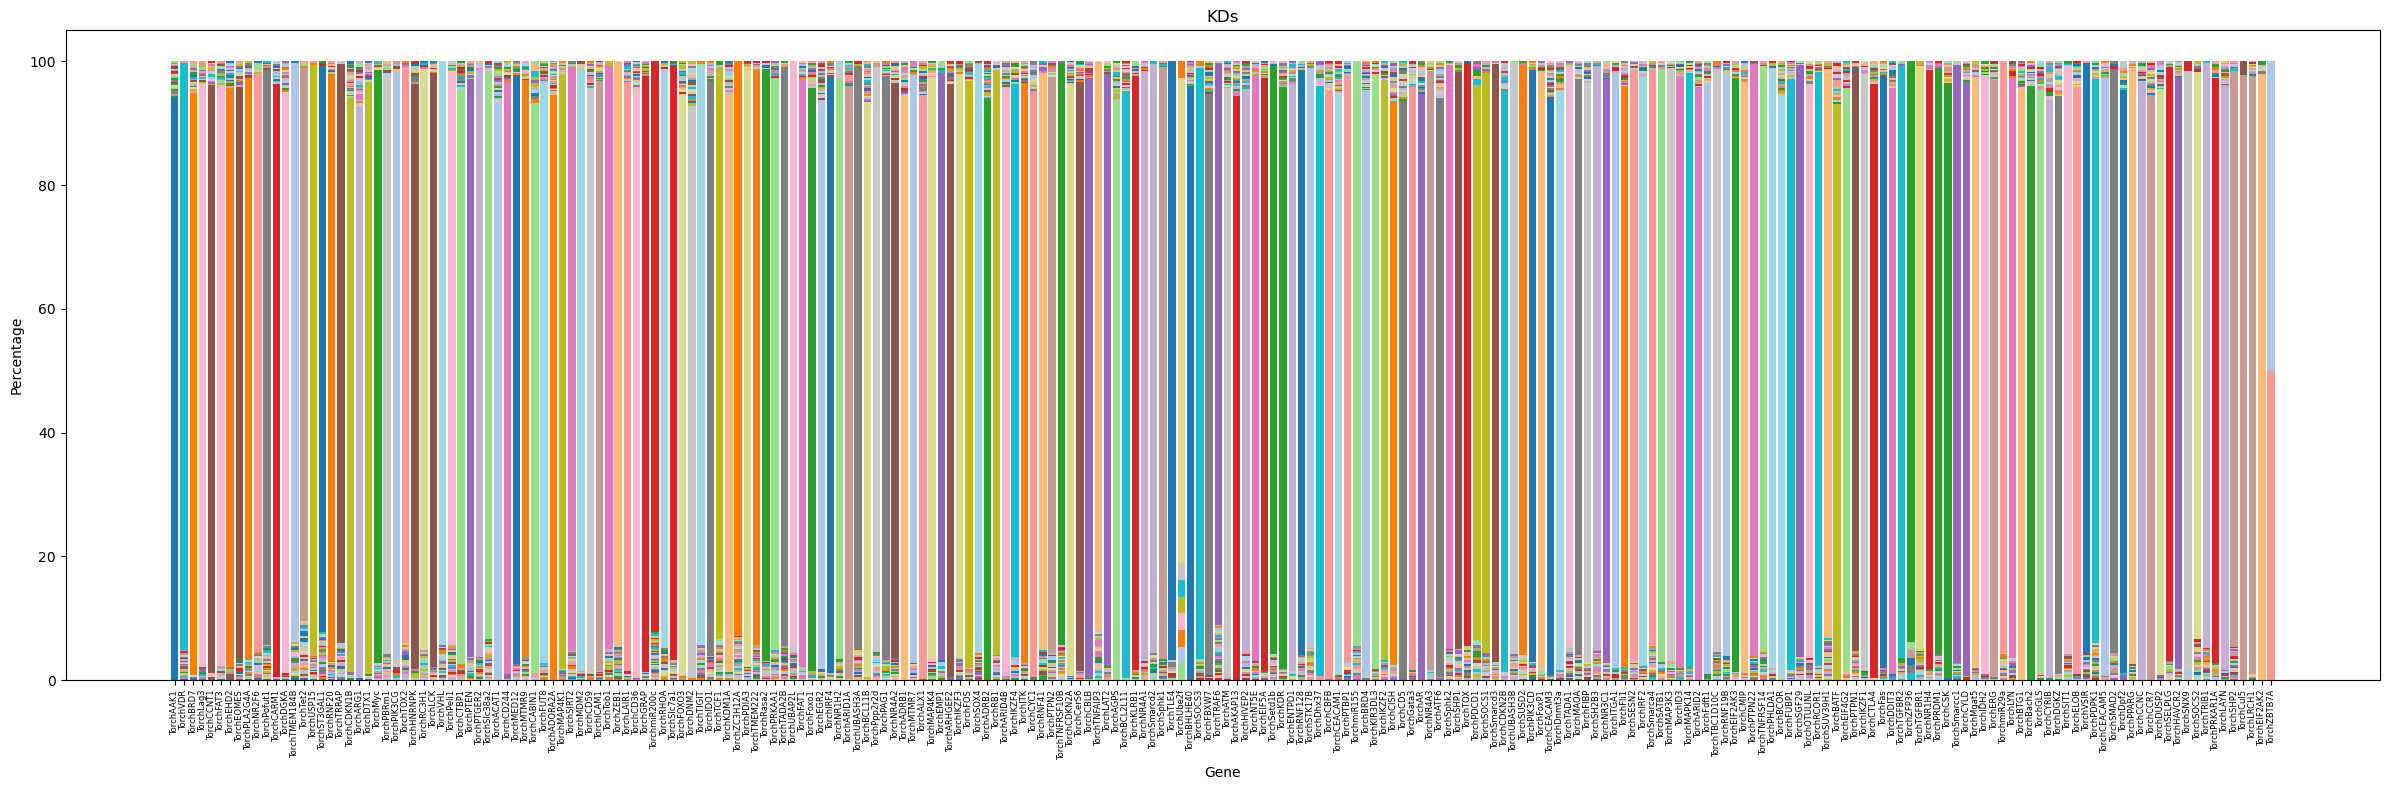

In [47]:
# Aggregate data for the bar plot
ss = merged_df[(merged_df['construct_prefix'] == "kd") & (merged_df['barcode_prefix'] == "kd")]
data = []
unique_genes = ss['construct'].dropna().unique()
for gene in unique_genes:
    filtered_df = ss[ss['construct'] == gene]
    counts = filtered_df['barcode'].value_counts(normalize=True) * 100
    for barcode, percentage in counts.items():
        data.append({'construct': gene, 'barcode': barcode, 'percentage': percentage})

plot_data = pd.DataFrame(data)

plot_data.head()
plt.figure(figsize=(24, 8))
colors = plt.cm.tab20.colors  # Use a colormap for distinct colors
bottoms = {construct: 0 for construct in unique_genes}
for i, (barcode, group) in enumerate(plot_data.groupby('barcode')):
    percentages = group.set_index('construct')['percentage']
    plt.bar(percentages.index, percentages, bottom=[bottoms[gene] for gene in percentages.index],
            color=colors[i % len(colors)], edgecolor='none', linewidth=0, label=barcode)
    for gene in percentages.index:
        bottoms[gene] += percentages[gene]

# Add labels and legend
plt.ylabel('Percentage')
plt.xlabel('Gene')
plt.xticks(fontsize=6)
plt.title('KDs')
plt.xticks(rotation=90)
plt.legend().remove()
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/base_kd_distribution.svg", format="svg")
plt.show()

### Plot construct counts vs. barcode counts

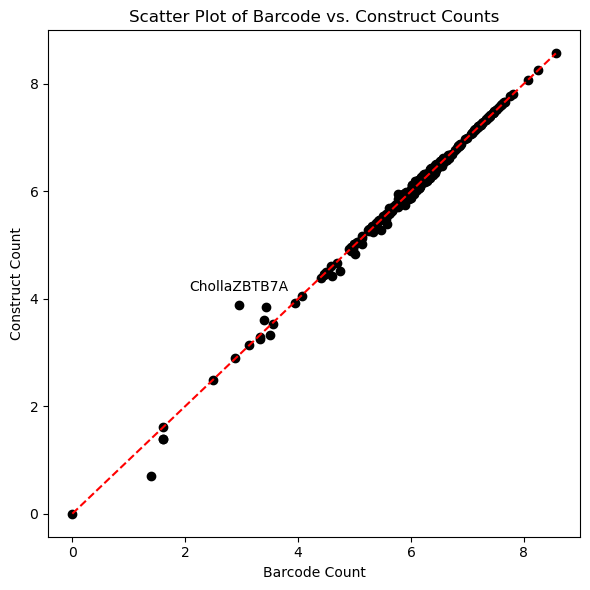

In [5]:
barcode_counts = merged_df['barcode'].value_counts()
construct_counts = merged_df['construct'].value_counts()

plot_df = pd.DataFrame({'barcode_count': barcode_counts, 'construct_count': construct_counts})
plt.figure(figsize=(6, 6))
plt.scatter(np.log(plot_df['barcode_count']), np.log(plot_df['construct_count']), c="black")
plt.xlabel('Barcode Count')
plt.ylabel('Construct Count')
plt.title('Scatter Plot of Barcode vs. Construct Counts')

min_val = min(np.log(plot_df['barcode_count']).min(), np.log(plot_df['construct_count']).min())
max_val = max(np.log(plot_df['barcode_count']).max(), np.log(plot_df['construct_count']).max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y')

# Identify points above the y=x line
above_line = (np.log(plot_df['barcode_count'])+0.7) < np.log(plot_df['construct_count'])

# Get the indices (barcodes) of these points
barcodes_above = plot_df.index[above_line]

# Annotate the points
for barcode in barcodes_above:
    x = np.log(plot_df.loc[barcode, 'barcode_count'])
    y = np.log(plot_df.loc[barcode, 'construct_count'])
    plt.annotate(barcode, (x, y), textcoords="offset points", xytext=(0,10), ha='center') 

plt.tight_layout()
plt.show()

#### Compute the percentage of barcodes correctly assigned

In [146]:
merged_df.head()

,barcode,construct,is_correct
ID,,,
m84127_250131_231902_s2/100007956/ccs,CardonYescarta,CardonYescarta,True
m84127_250131_231902_s2/100008059/ccs,TorchBHLHE40,TorchALX1,False
m84127_250131_231902_s2/100008063/ccs,ChollaCD59,ChollaMED12,False
m84127_250131_231902_s2/100008074/ccs,SaguaroAIFM2,SaguaroAIFM2,True
m84127_250131_231902_s2/100008094/ccs,KingcupCD28PYAPonly,KingcupCD28PYAP,False


In [150]:
# fish out the prefix from the key column of ratio_df
def get_prefix(name):
    prefixes = ["Cholla", "Saguaro", "Torch", "PricklyPear", "Kingcup", "Cardon", "Fishhook"]
    for prefix in prefixes:
        if str(name).startswith(prefix):
            return prefix
    return "Other"
merged_df['construct_prefix'] = merged_df['construct'].apply(get_prefix)
merged_df['barcode_prefix'] = merged_df['barcode'].apply(get_prefix)
# drop is_correct column if it exists
if 'is_correct' in merged_df.columns:
    merged_df = merged_df.drop(columns=['is_correct'])

# drop barcode_prefixes Cardon, Kingcup, and Fishhook
mask = merged_df['barcode_prefix'].isin(['Cardon', 'Kingcup', 'Fishhook'])
merged_df = merged_df[~mask]
merged_df.head()

,barcode,construct,construct_prefix,barcode_prefix
ID,,,,
m84127_250131_231902_s2/100008059/ccs,TorchBHLHE40,TorchALX1,Torch,Torch
m84127_250131_231902_s2/100008063/ccs,ChollaCD59,ChollaMED12,Cholla,Cholla
m84127_250131_231902_s2/100008074/ccs,SaguaroAIFM2,SaguaroAIFM2,Saguaro,Saguaro
m84127_250131_231902_s2/100008300/ccs,SaguaroBATF3,SaguaroBATF3,Saguaro,Saguaro
m84127_250131_231902_s2/100008446/ccs,ChollaDnmt3a,ChollaDnmt3a,Cholla,Cholla


In [151]:
counter = 0
prefixes = ["Cholla", "Saguaro", "Torch", "PricklyPear"]
groupings = {
    "Cholla": 0,
    "Saguaro": 0,
    "Torch": 0,
    "PricklyPear": 0,
    "Other": 0,
    "Correct": 0
}
for (i, (c, b, _, _, )) in merged_df.iterrows():
    if (c != b):
        match_found = False
        for p in prefixes:
            if c.startswith(p) and b.startswith(p):
                groupings[p] += 1
                match_found = True
                break
        if not match_found:
            groupings["Other"] += 1
    else:
        groupings["Correct"] += 1
    counter += 1

In [152]:
merged_df.head()

,barcode,construct,construct_prefix,barcode_prefix
ID,,,,
m84127_250131_231902_s2/100008059/ccs,TorchBHLHE40,TorchALX1,Torch,Torch
m84127_250131_231902_s2/100008063/ccs,ChollaCD59,ChollaMED12,Cholla,Cholla
m84127_250131_231902_s2/100008074/ccs,SaguaroAIFM2,SaguaroAIFM2,Saguaro,Saguaro
m84127_250131_231902_s2/100008300/ccs,SaguaroBATF3,SaguaroBATF3,Saguaro,Saguaro
m84127_250131_231902_s2/100008446/ccs,ChollaDnmt3a,ChollaDnmt3a,Cholla,Cholla


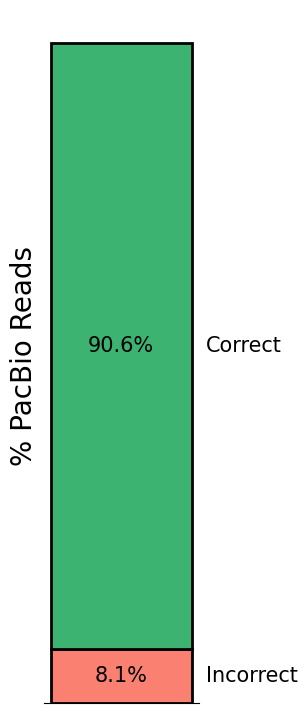

In [154]:
# Define the data for the plot
total = sum(groupings.values())
d = {
    "Correct": groupings["Correct"] / total,
    "Incorrect": (groupings["Cholla"] + groupings["Saguaro"] + groupings["Torch"] + groupings["PricklyPear"]) / total
}

plot_df = pd.DataFrame.from_dict(d, orient='index', columns=['Value'])
plot_df["Name"] = plot_df.index

# Sort and reset index
plot_df = plot_df.sort_values("Value").reset_index(drop=True)

# Create the plot
fig, ax = plt.subplots(figsize=(2, 9))

bottom = 0
colors = ["salmon", "mediumseagreen"]

for i, row in plot_df.iterrows():
    height = row["Value"]
    ax.bar(0, height, bottom=bottom, color=colors[i % len(colors)], edgecolor="black", linewidth=2)
    if height > 0.03:
        ax.text(0, bottom + height / 2, f"{round(height * 100, 1)}%", ha="center", va="center", size=15)
    ax.text(0.48, bottom + height / 2, f"{row['Name']}", ha="left", va="center", size=15)

    bottom += height

# Style the plot
plt.xlabel("")
plt.ylabel("% PacBio Reads", size=20)
plt.title("")
plt.xticks([], [])
plt.yticks([], [])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# save plot as svg
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/base_screen_modification_overall_correct_rate_bar_plot.svg", format="svg")
plt.show()

In [115]:
# plot by correctness
def classify_construct_correctness(df):
    # check if the full barcode matches the full construct
    df["is_correct"] = df["barcode"] == df["construct"]

    
    obs = df.groupby('barcode').size().to_dict()
    cor = df.groupby('barcode')['is_correct'].sum().to_dict()


    ratio_dict = {key: cor[key] / obs[key] for key in cor if key in obs}

    # length_dict_for_constructs = df.groupby('construct')['length'].first().to_dict()

    ratio_df = pd.DataFrame({
        'key': list(ratio_dict.keys()),
        'value': list(ratio_dict.values()),
        'obs': list(obs.values()),
        # 'length': [length_dict_for_constructs.get(key, 0) for key in ratio_dict]
    })
    
    return ratio_df

ratio_df = classify_construct_correctness(merged_df)

In [117]:
# show all of constructs with correctness ratio below 0.5 and above 100 observations
# show all of constructs with correctness ratio below 0.5 and above 100 observations
low_correctness = ratio_df[(ratio_df['value'] < 0.5) & (ratio_df['obs'] > 100)]
print(low_correctness)

                          key     value   obs
236              Fishhook47G4  0.003003   333
239          FishhookCarvykti  0.021490   698
240            FishhookSJ25C1  0.027523   109
262       KingcupCAR1CCTCTLA4  0.000000  3783
263       KingcupCAR2CCTCTLA4  0.000000  2701
266       KingcupCD2841BBCD27  0.000000  2283
271       KingcupCD28PYAPonly  0.000000  3204
275  KingcupCD40CD3εITAMDAP12  0.000000  3685


/tmp/ipykernel_6576/1996447661.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


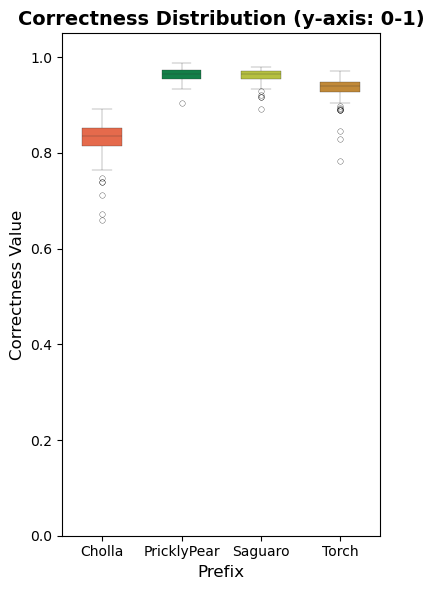

In [144]:
# Plot with y-axis range 0-1
prefix_colors = {
    "Fishhook": "#6fb5d9",
    "Saguaro": "#c8d52c",
    "Torch": "#d88d21",
    "Cholla": "#FF5A32",
    "Cardon": "#736357",
    "PricklyPear": "#019147",
    "Kingcup": "#1b75bb",
    # 'Other': '#CDD5E0'
}

# fish out the prefix from the key column of ratio_df
def get_prefix(name):
    prefixes = ["Cholla", "Saguaro", "Torch", "PricklyPear", "Kingcup", "Cardon", "Fishhook"]
    for prefix in prefixes:
        if str(name).startswith(prefix):
            return prefix
    return "Other"
ratio_df['prefix'] = ratio_df['key'].apply(get_prefix)
ratio_df.head()

# drop Kingcup Other and Fishhook
ratio_df = ratio_df[~ratio_df['prefix'].isin(['Kingcup', 'Other', 'Fishhook', 'Cardon'])]
# ratio df obs > 100
ratio_df = ratio_df[ratio_df['obs'] >= 100]

plt.figure(figsize=(4, 6))
sns.boxplot(
    x='prefix',
    y='value',
    data=ratio_df,
    palette=prefix_colors,
    width=0.5,  # Adjust box width for better spacing
    linewidth=0.2,  # Thicker box edges
    flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='black', markersize=4, markeredgewidth=0.2)
)
plt.ylim(0, 1.05)
plt.title("Correctness Distribution (y-axis: 0-1)", fontsize=14, weight='bold')
plt.xlabel("Prefix", fontsize=12)
plt.ylabel("Correctness Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/base_screen_modification_overall_correct_rate_box_plot_0_1.svg", format="svg")
plt.show()

/tmp/ipykernel_14666/2298001771.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


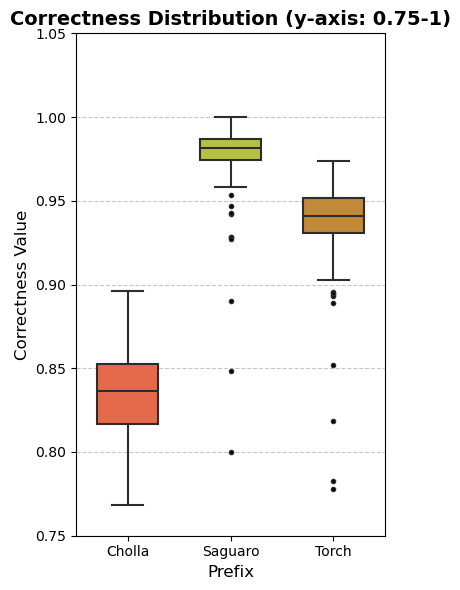

In [21]:
# Plot with y-axis range 0.6-1
plt.figure(figsize=(4, 6))
sns.boxplot(
    x='prefix',
    y='value',
    data=ratio_df,
    palette=prefix_colors,
    width=0.6,  # Adjust box width for better spacing
    linewidth=1.5,  # Thicker box edges
    flierprops=dict(marker='o', markerfacecolor='black', markersize=3)  # Filled in circles for outliers
)
plt.ylim(0, 1)
plt.title("Correctness Distribution (y-axis: 0.75-1)", fontsize=14, weight='bold')
plt.xlabel("Prefix", fontsize=12)
plt.ylabel("Correctness Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.ylim(0.75, 1.05)
plt.tight_layout()
plt.savefig("/home/hartmana_stanford_edu/projects/pacbio_crispr_all/scripts/plots/base_screen_modification_overall_correct_rate_box_plot_0_0p75.svg", format="svg")
plt.show()